<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2025/blob/main/HNN_vs_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/greydanus/hamiltonian-nn.git

fatal: destination path 'hamiltonian-nn' already exists and is not an empty directory.


# HAMILTONIAN NEURAL NETWORKS

[Original Paper](https://arxiv.org/pdf/1906.01563)

<img src=https://github.com/greydanus/hamiltonian-nn/raw/master/static/overall-idea.png>

In [ ]:
import os
os.chdir('/content/hamiltonian-nn')

In [ ]:
!python3 experiment-2body/train.py  --verbose
!python3 experiment-2body/train.py  --baseline --verbose

Training HNN model:
Successfully loaded data from /content/hamiltonian-nn/experiment-2body/2body-orbits-dataset.pkl
step 0, train_loss 5.6357e-02, test_loss 5.1171e-02, grad norm 1.0671e-02, grad std 5.0168e-04
step 200, train_loss 9.1158e-04, test_loss 4.8699e-04, grad norm 1.6677e-04, grad std 6.2716e-05
step 400, train_loss 1.4202e-04, test_loss 1.6039e-04, grad norm 1.5198e-05, grad std 1.8933e-05
step 600, train_loss 1.1207e-04, test_loss 1.1106e-04, grad norm 9.7602e-06, grad std 1.5172e-05
step 800, train_loss 7.7935e-05, test_loss 7.4999e-05, grad norm 5.3293e-05, grad std 3.5453e-05
step 1000, train_loss 3.9586e-05, test_loss 4.5924e-05, grad norm 1.2575e-05, grad std 1.7222e-05
step 1200, train_loss 2.7227e-05, test_loss 3.9967e-05, grad norm 1.2551e-05, grad std 1.7205e-05
step 1400, train_loss 4.4232e-05, test_loss 2.9213e-05, grad norm 2.5062e-05, grad std 2.4312e-05
step 1600, train_loss 2.2823e-05, test_loss 2.9644e-05, grad norm 8.7842e-06, grad std 1.4394e-05
step 1800

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch, time, sys
import numpy as np
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-2body'
sys.path.append(EXPERIMENT_DIR)

from nn_models import MLP
from hnn import HNN
from utils import L2_loss, to_pickle, from_pickle
from data import get_dataset, coords2state, get_orbit, random_config
from data import potential_energy, kinetic_energy, total_energy

In [ ]:


DPI = 300
FORMAT = 'pdf'

def get_args():
    return {'input_dim': 2*4, # two bodies, each with q_x, q_y, p_z, p_y
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'input_noise': 0.,
         'batch_size': 200,
         'nonlinearity': 'tanh',
         'total_steps': 1500,
         'field_type': 'solenoidal',
         'print_every': 200,
         'verbose': True,
         'name': '2body',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d



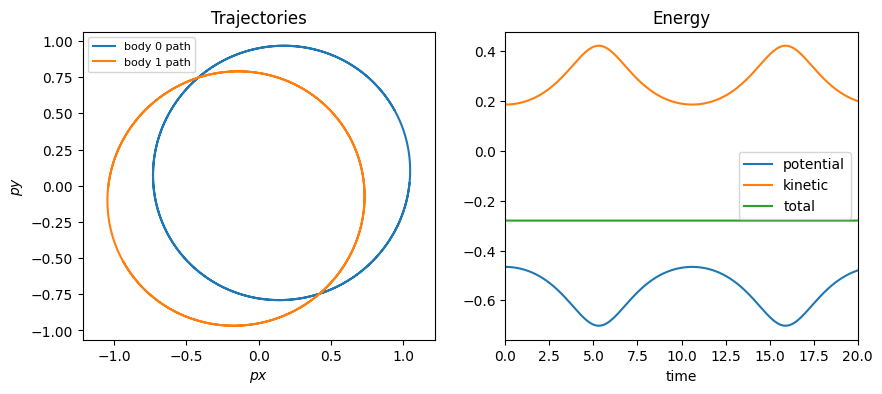

In [ ]:
args = ObjectView(get_args())
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 20], rtol = 1e-10)

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()
fig.savefig('{}/orbits-dataset.{}'.format(args.fig_dir, FORMAT))

In [ ]:


def load_model(args, baseline=False):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
            field_type=args.field_type, baseline=baseline)

    case = 'baseline' if baseline else 'hnn'
    path = "{}/{}-orbits-{}.tar".format(args.save_dir, args.name, case)
    model.load_state_dict(torch.load(path))
    return model

args = ObjectView(get_args())
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)



In [ ]:


# for integrating a vector field parameterized by a NN or HNN
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,2).T
    return deriv.reshape(-1)



In [ ]:
np.random.seed(1)
t_points = 2000
t_span = [0,100]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn_ann = lambda t, y0: model_update(t, y0, base_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn_ann)


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn)

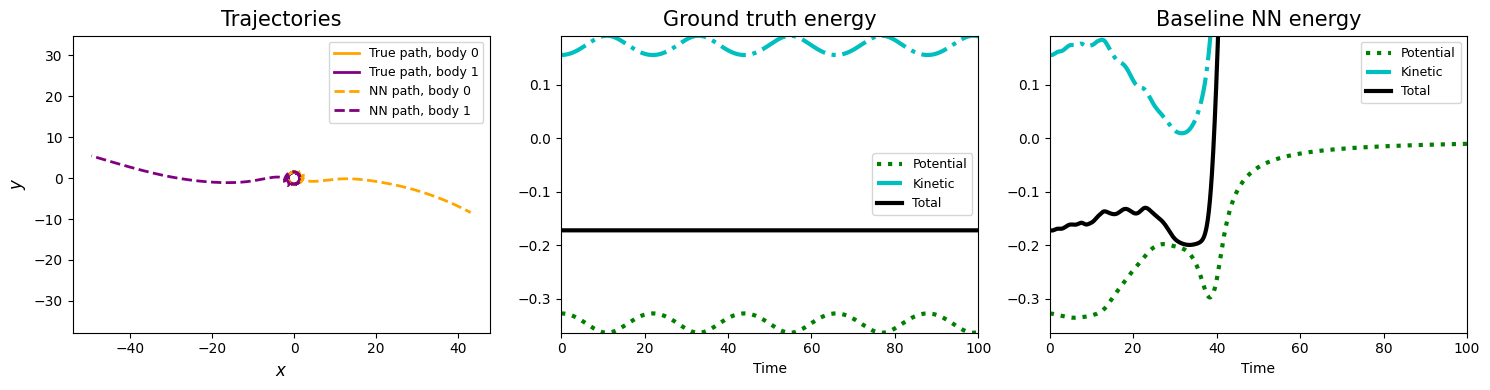

In [ ]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)

for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-base-example.{}'.format(args.fig_dir, FORMAT))

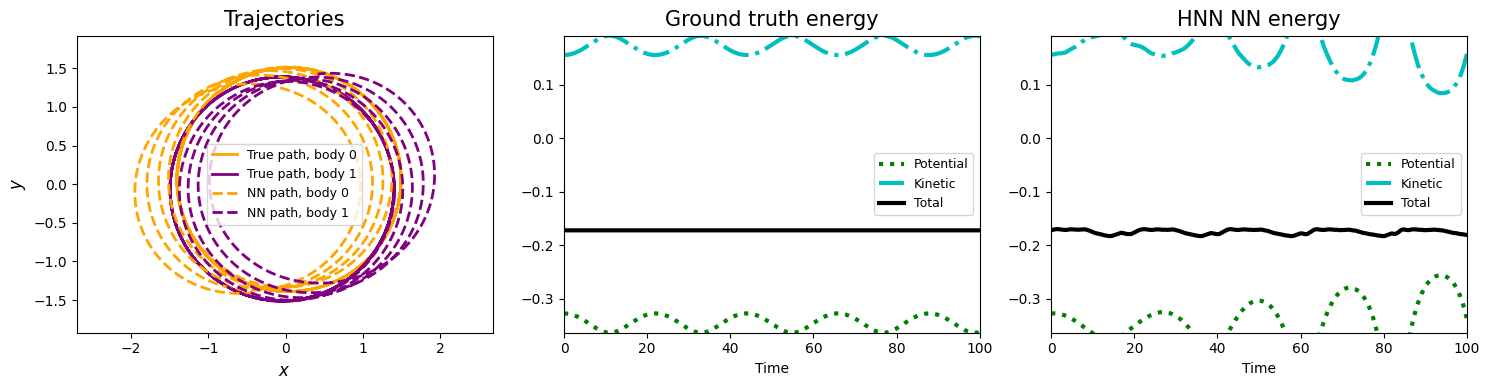

In [ ]:

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)

for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-hnn-example.{}'.format(args.fig_dir, FORMAT))

In [ ]:
def plot_orbits(fig, k, tail=10000, pfrac=0.05, fs=28, ms=20, lw=3, tpad=15):
    xmin = ymin = np.min([orbit[:,1,:].min(), orbit[:,2,:].min()])
    xmax = ymax = np.max([orbit[:,1,:].max(), orbit[:,2,:].max()])
    pad = (xmax-xmin)*pfrac
    xmin -= pad
    xmax += pad
    ymin -= pad
    ymax += pad

    colors = [(0,0,0), (.6,.6,.6)]
    t = max(0, k-tail)

    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=fs, pad=tpad)
    for i, path in enumerate(orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(1,0,0), (1,.6,.6)]
    plt.subplot(1,3,2)
    plt.title('Baseline NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(0,0,1), (.6,.6,1)]
    plt.subplot(1,3,3)
    plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    plt.tight_layout()

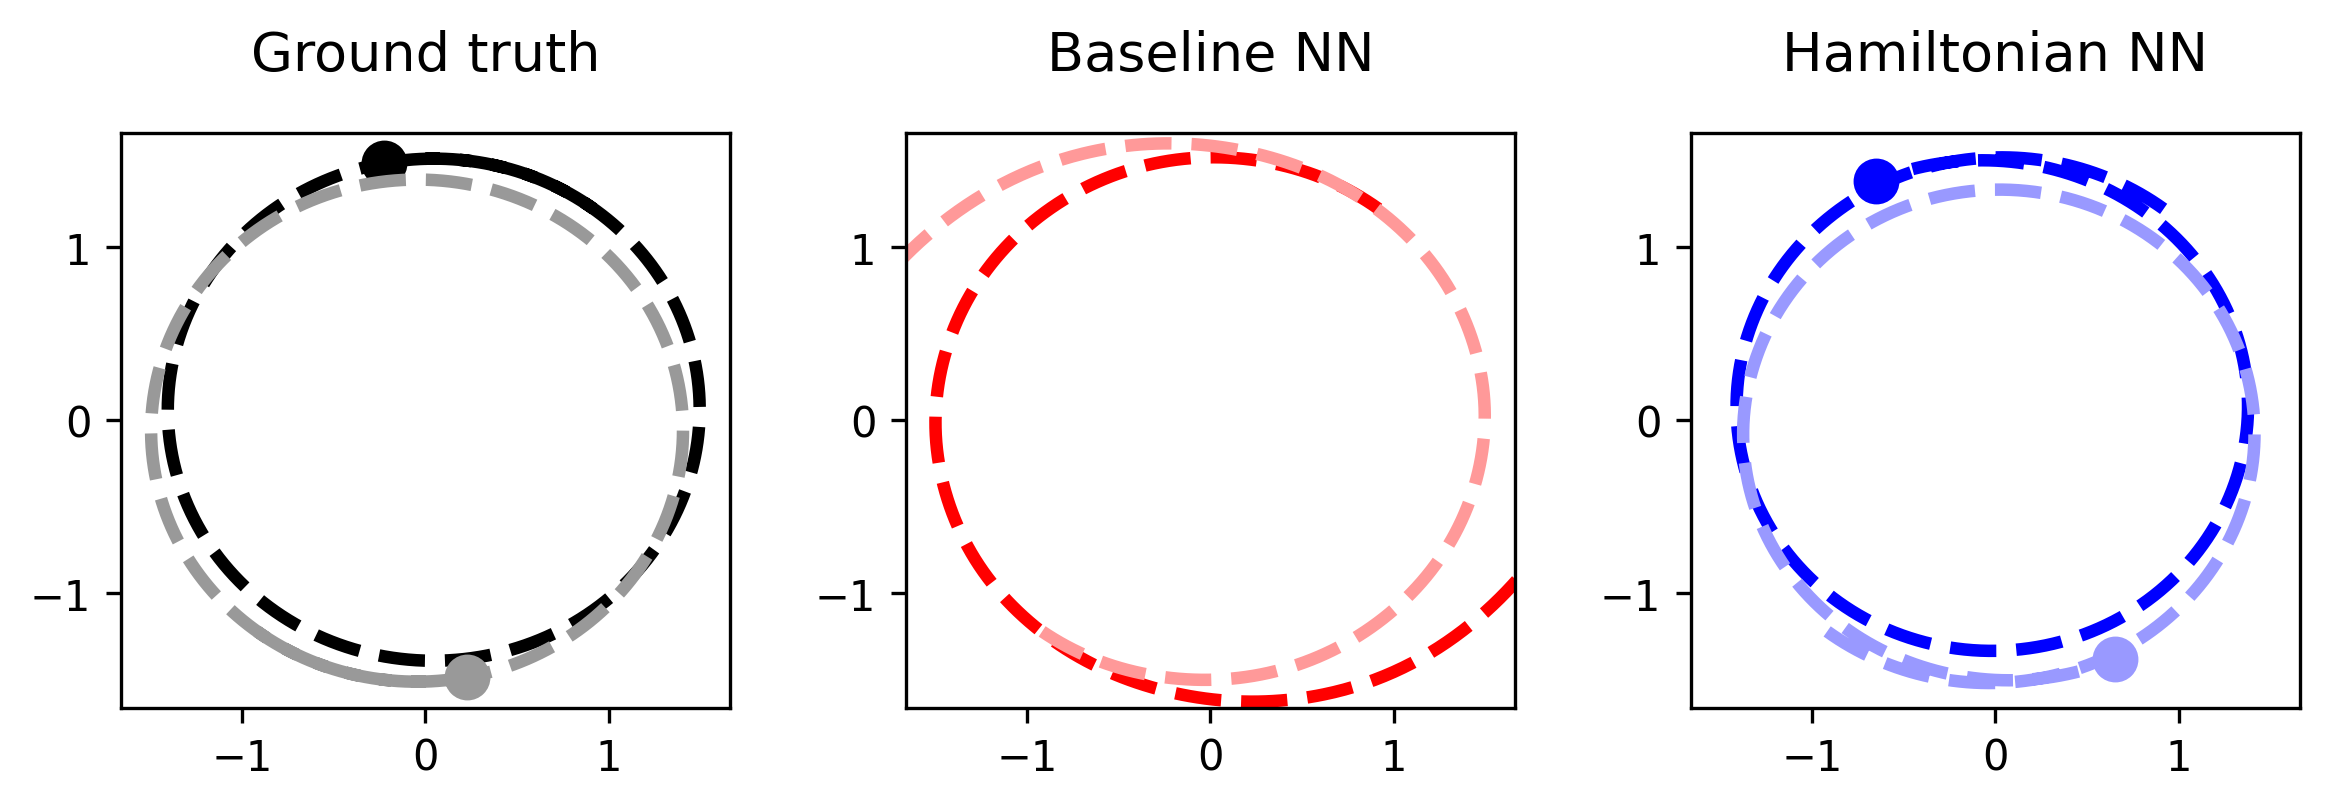

In [ ]:


dpi = 40
k = 500
fig = plt.figure(figsize=[8,2.8], dpi=DPI)
plot_orbits(fig, k, fs=13)
plt.show() ; fig.savefig('{}/orbits-compare.{}'.format(args.fig_dir, FORMAT))



In [ ]:
t_points = 200
t_span = [0,40]
trials = 5*3

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):

    np.random.seed(trial_ix)
    state = random_config()

    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))

    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, base_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))

    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, hnn_model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))

true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

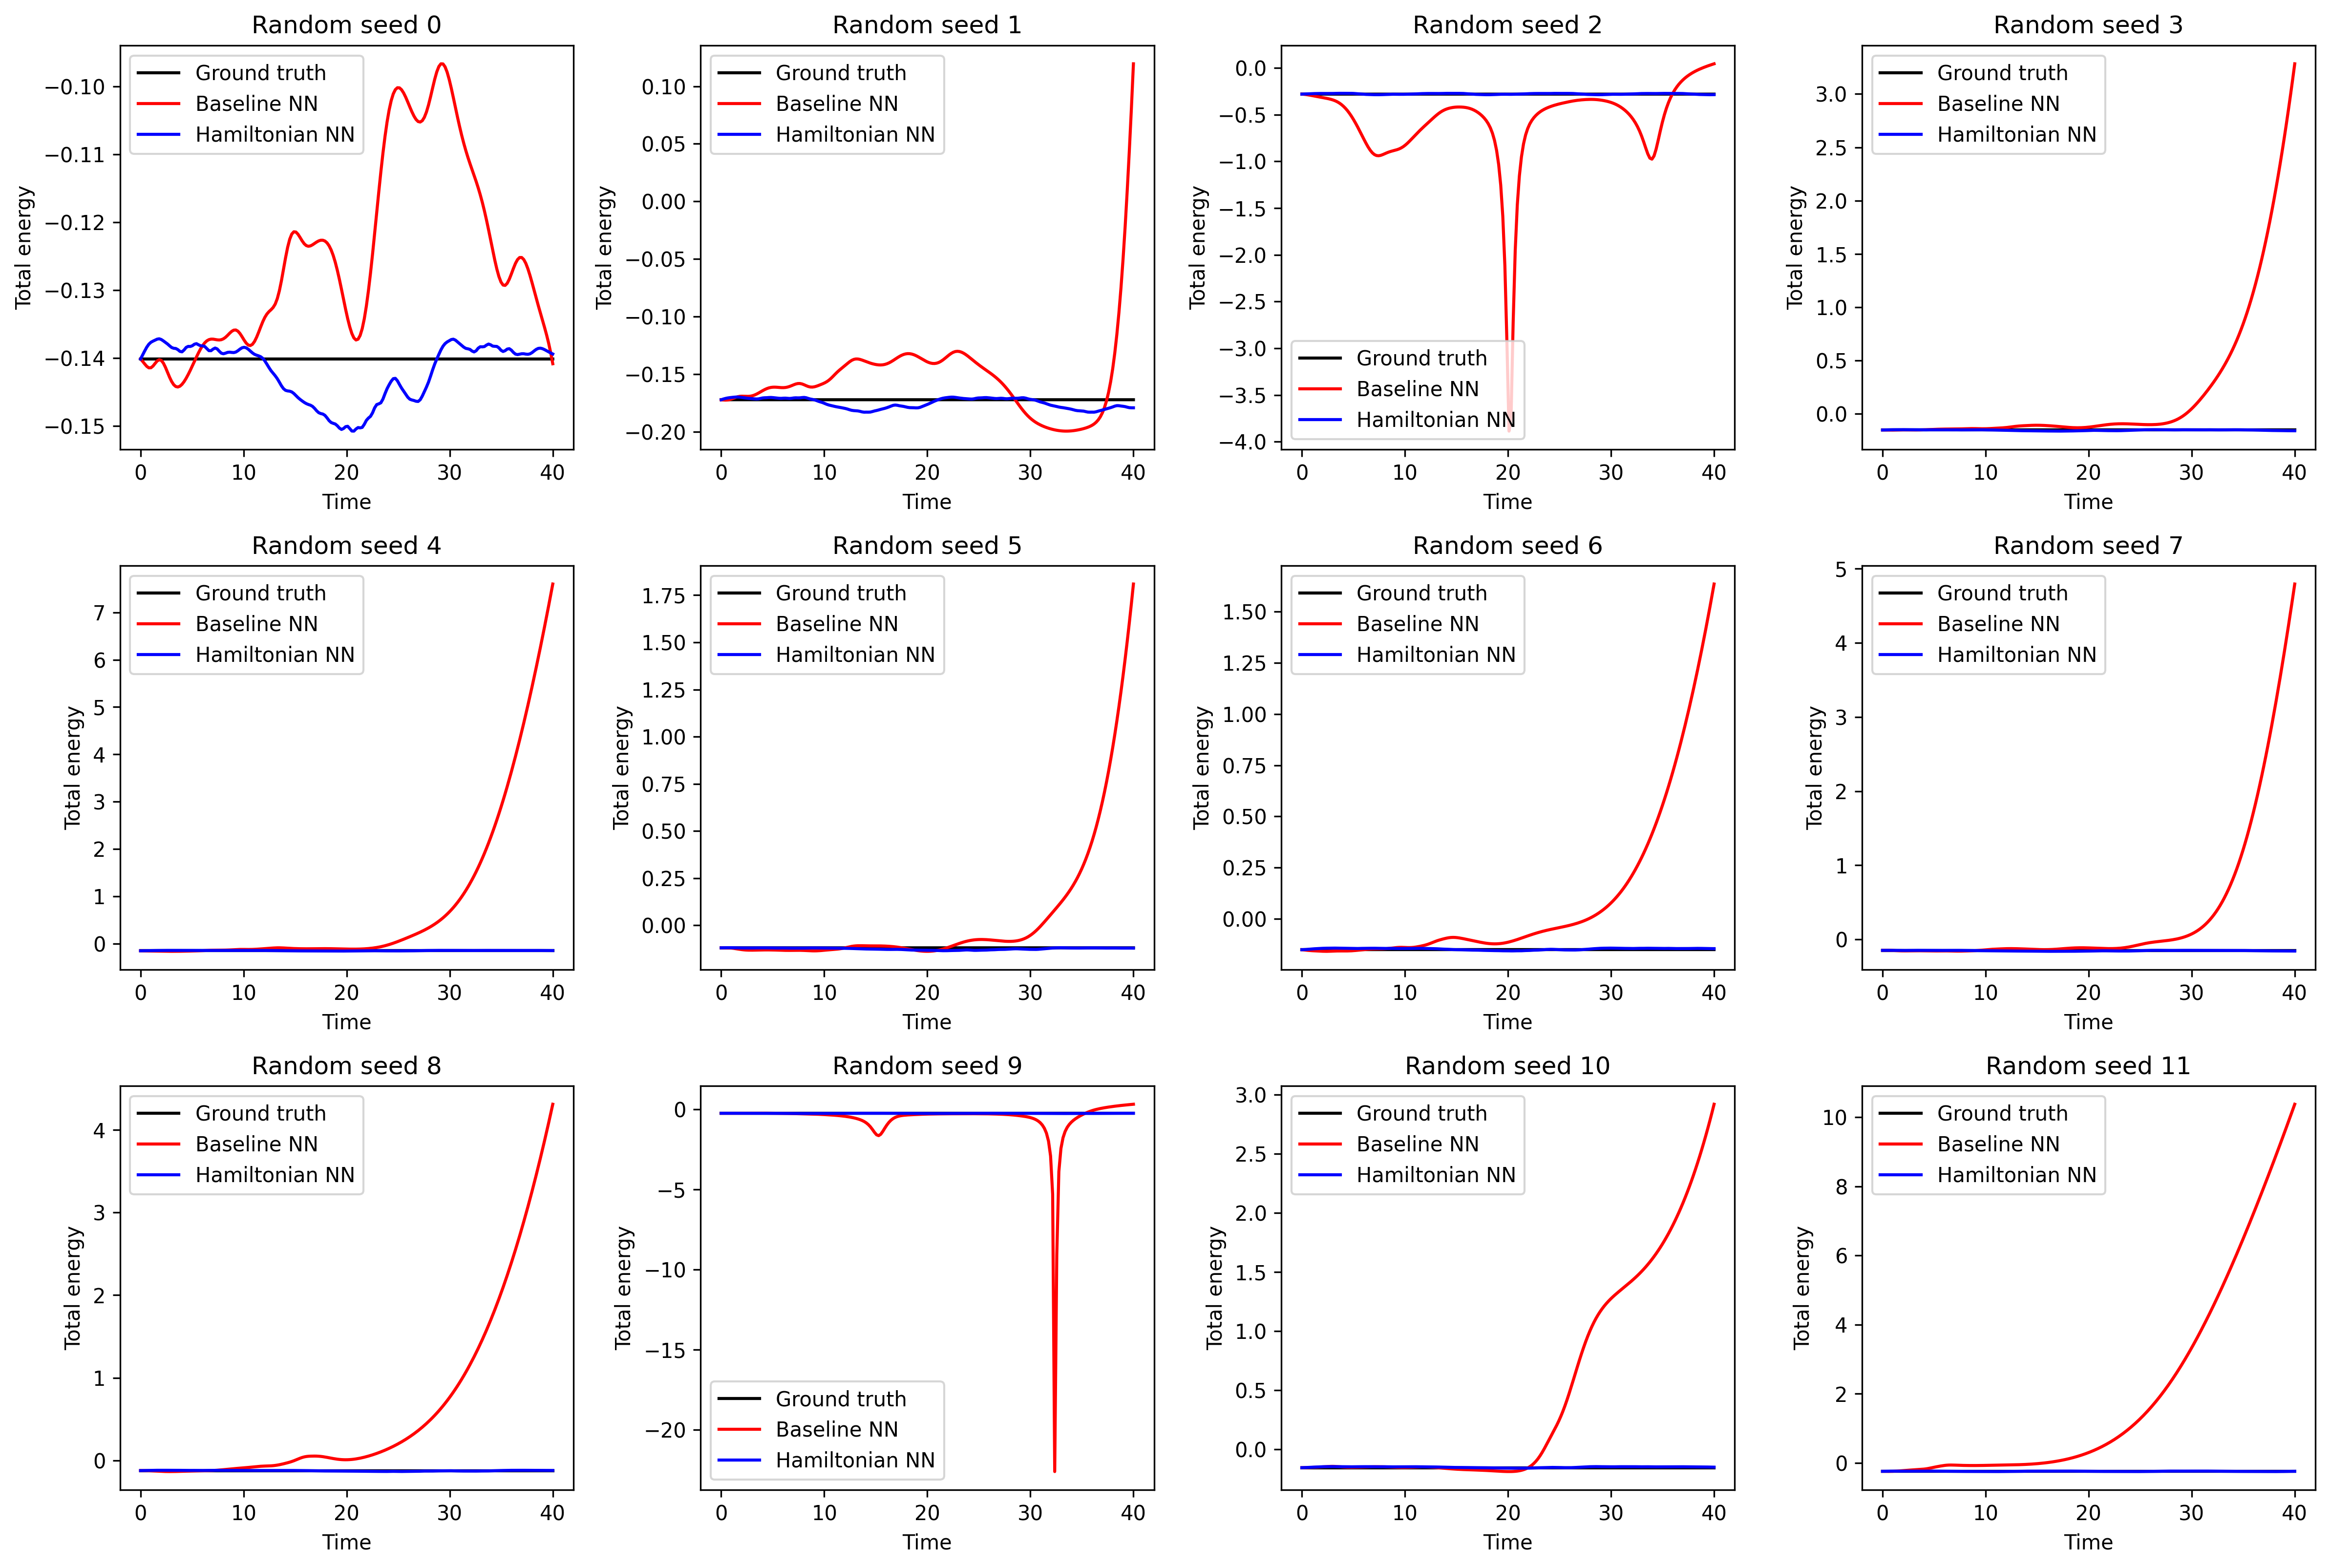

In [ ]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s], dpi=DPI)
for i in range(N):

    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed {}'.format(i))
    plt.plot(t_domain, true_energies[i], 'k-', label='Ground truth')
    plt.plot(t_domain, base_energies[i], 'r-', label='Baseline NN')
    plt.plot(t_domain, hnn_energies[i], 'b-', label='Hamiltonian NN')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-total-energy.{}'.format(args.fig_dir, FORMAT))